In [1]:
# Этап I. 

#КОД Для загрузки Ground Truth. Если не нужно - не запускать.

import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

dir_path = '/home/user1/data/train Росатом' # ПУТЬ К ТЕСТОВОМУ ДАТАСЕТУ с ОТВЕТАМИ!!

# Путь к папкам
images_dir = os.path.join(dir_path, 'train/imgs')  # Папка с изображениями
labels_dir = os.path.join(dir_path, 'train/labels')  # Папка с разметками
labels_text_dir = os.path.join(dir_path, "train/labels_with_text")

# Список для хранения данных таблицы
data = []

# Обход папки с изображениями
for image_file in os.listdir(images_dir):
    if image_file.endswith(('.png', '.jpg', '.jpeg', '.JPG')):
        image_path = os.path.join(images_dir, image_file)
        label_path = os.path.join(labels_dir, os.path.splitext(image_file)[0] + '.txt')
        label_text_path = os.path.join(labels_text_dir, os.path.splitext(image_file)[0] + '.bbox')

        # Проверка наличия файла разметки
        if os.path.exists(label_path):


            # Чтение текстовых меток
            if os.path.exists(label_text_path):
                with open(label_text_path, 'r') as f:
                    label_text = ''.join(f.readlines())
                    label_text = label_text.replace('\n', '')
            else:
                label_text = np.NaN


            # Чтение текстовых меток
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    label = ''.join(f.readlines())
            else:
                label = np.NaN

            # Добавление данных в таблицу
            data.append([image_file, label, label_text])

# Создание DataFrame с изображениями и текстовыми метками
gt = pd.DataFrame(data, columns=['image_file', 'label', 'label_text'])
gt.head()


,image_file,label,label_text
0,301.JPG,0 0.495625 0.472500 0.556250 0.401667\n,"""АМ116.06.00.901-03"""
1,299.jpg,0 0.477766 0.447012 0.378501 0.285247\n,"""АМ116.06.00.901-03 1"""
2,393.jpg,0 0.464706 0.504657 0.326797 0.446569\n,"""АМ116.06.00.962 2"""
3,453.jpg,0 0.489542 0.528676 0.762092 0.348529\n,"""АМ116.06.01.301 31"""
4,60.JPG,0 0.476562 0.321573 0.703125 0.489919\n,"""1391-30-0109 241"""


In [2]:
# КОД OCR

from paddleocr import PaddleOCR
import logging
import time
logging.getLogger("ppocr").setLevel(logging.ERROR)

ocr = PaddleOCR(
    use_angle_cls=False, 
    lang='en',
    ocr_version='PP-OCRv4',
    use_space_char=True,
    use_gpu=True,
    enable_mkldnn=True,  
    use_tensorrt=True, 
    enable_fp16=True,
)


def multi_angle_ocr(image, angles=[0, 45, 90, 135, 180, 225, 270, 315]):
    """Функция для распознавания текста на изображении с учетом различных углов"""
    start_total = time.time()
    
    best_text = ""
    max_confidence = 0
    best_rotated = None
    best_box = None
    best_angle = 0

    if image is None:
        return best_text, best_rotated, best_box

    height, width = image.shape[:2]
    max_dim = max(height, width)
    if max_dim > 640:
        scale = 640.0 / max_dim
        new_width = int(width * scale)
        new_height = int(height * scale)
        image = cv2.resize(image, (new_width, new_height))
    
    height, width = image.shape[:2]
    center = (width // 2, height // 2)

    for angle in angles:
        
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, rotation_matrix, (int(width), int(height)))
        result = ocr.ocr(rotated, cls=False)
        

        if result[0]:
            confidence = sum(line[1][1] for line in result[0])
            if confidence > max_confidence:
                max_confidence = confidence
                best_text = " ".join([line[1][0] for line in result[0]])
                best_rotated = rotated
                best_angle = angle

                boxes = np.array([line[0] for line in result[0]])
                min_x = np.min(boxes[:, :, 0])
                min_y = np.min(boxes[:, :, 1])
                max_x = np.max(boxes[:, :, 0])
                max_y = np.max(boxes[:, :, 1])
                
                width_box = max_x - min_x
                height_box = max_y - min_y
                center_x = min_x + width_box/2
                center_y = min_y + height_box/2
                
                width_box *= 1
                height_box *= 1
                
                points = np.array([[center_x - width_box/2, center_y - height_box/2],
                                 [center_x + width_box/2, center_y - height_box/2],
                                 [center_x + width_box/2, center_y + height_box/2],
                                 [center_x - width_box/2, center_y + height_box/2]])
                
                inv_rotation_matrix = cv2.getRotationMatrix2D(center, -best_angle, 1.0)
                
                ones = np.ones(shape=(len(points), 1))
                points_ones = np.hstack([points, ones])
                transformed_points = inv_rotation_matrix.dot(points_ones.T).T
                
                min_x = np.min(transformed_points[:, 0])
                min_y = np.min(transformed_points[:, 1])
                max_x = np.max(transformed_points[:, 0])
                max_y = np.max(transformed_points[:, 1])
                
                width_box = max_x - min_x
                height_box = max_y - min_y
                center_x = min_x + width_box/2
                center_y = min_y + height_box/2
                
                rel_center_x = center_x / width
                rel_center_y = center_y / height
                rel_width = width_box / width
                rel_height = height_box / height
                
                best_box = [rel_center_x, rel_center_y, rel_width, rel_height]
        
    return best_text, best_rotated, best_box


In [3]:
# ИНИЦИАЛИЗАЦИЯ МОДЕЛИ CLIP.

# P.S. - не ругайте за то что подгружаются из huggingface, это же хакатон)
#        в нормальном проде это все без проблем упаковывается и работает локально.

from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

# Функция для получения векторных представлений изображений и текста
def get_clip_embeddings(image=None, text=None):
    result = {}
    with torch.no_grad():
        if image is not None:
            if isinstance(image, np.ndarray):
                image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if isinstance(image, str):
                image = Image.open(image)
                
            inputs = processor(images=image, return_tensors="pt").to(device)
            image_features = model.get_image_features(**inputs)
            result['image_embedding'] = image_features.cpu().numpy()
        
        if text is not None and isinstance(text, str):
            inputs = processor(text=text, return_tensors="pt", padding=True).to(device)
            text_features = model.get_text_features(**inputs)
            result['text_embedding'] = text_features.cpu().numpy()
    
    return result

In [4]:
# Подгружаем нашу "базу данных".
# Она в формате DataFrame. Можно посмотреть содержимое.
# Мы не обрабатывали и не добавляли в нее данные вручную после открытия тестового датасета.
# У нас всё честно))

import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

# Загружаем базу данных
grouped = pd.read_pickle('grouped.pkl')

grouped.head()

,image_file,count,ocr_text_embeddings,embeddings_image,embeddings_text
article,,,,,
1391-30-0109,"[60.JPG, 81.JPG, 80.JPG, 59.JPG, 77.jpg, 70.JP...",15,"[[0.017365314, 0.11561554, 0.07099361, 0.20430...","[[-0.24761134, -0.0367497, 0.051416826, 0.1916...","[[-0.025438841, 0.060193364, 0.06883027, 0.150..."
1391-30-1139,"[410.JPG, 362.JPG]",2,"[[0.08157718, 0.22039655, 0.011820257, 0.33380...","[[-0.1021947, 0.12941961, 0.0753935, -0.105946...","[[0.07487033, -0.05096645, 0.049642235, 0.1283..."
1391-30-1140,"[373.JPG, 346.JPG, 411.JPG]",3,"[[0.055068266, 0.09756765, 0.053187296, 0.2884...","[[-0.08799681, 0.21026927, 0.16012101, -0.1164...","[[0.06178923, -0.011043355, -0.021948034, 0.17..."
1391-30-1151,[92.jpg],1,"[[0.100430995, 0.24313453, 0.12627964, 0.12950...","[[-0.15982224, 0.053742856, 0.14010802, -0.014...","[[0.093301624, -0.049591593, 0.032554477, 0.12..."
1753-30-0124,"[413.JPG, 384.JPG]",2,"[[-0.047549512, 0.18820047, 0.06791867, 0.1052...","[[-0.0197642, 0.18334894, 0.20647895, -0.00318...","[[-0.04941526, 0.23083419, 0.07926907, 0.16700..."


In [5]:
# Код для предсказания артикула по изображению

# Функция для вычисления косинусного сходства
def calculate_cosine_similarity(embedding1, embedding2):

    embedding1 = embedding1.flatten()
    embedding2 = embedding2.flatten()
    
    dot_product = np.dot(embedding1, embedding2)
    
    norm1 = np.linalg.norm(embedding1)
    norm2 = np.linalg.norm(embedding2)
    
    similarity = dot_product / (norm1 * norm2)
    
    return similarity

def get_image_article_text(image_path):
    image = cv2.imread(image_path)
    
    best_text, rotated_image, box = multi_angle_ocr(image)

    # 
    if rotated_image is not None:
        image = rotated_image

    image_embedding = get_clip_embeddings(image=image)['image_embedding']
    text_embedding = get_clip_embeddings(text=best_text[:77])['text_embedding']

    image_distances = grouped['embeddings_image'].apply(lambda x: calculate_cosine_similarity(
        image_embedding,
        x 
    ))
    text_ocr_distances = grouped['ocr_text_embeddings'].apply(lambda x: calculate_cosine_similarity(
        text_embedding,
        x 
    ))
    text_article_distances = grouped['embeddings_text'].apply(lambda x: calculate_cosine_similarity(
        text_embedding,
        x 
    ))

    groups = pd.DataFrame(grouped.index, columns=['article'])
    groups['image_distance'] = image_distances.values
    groups['text_ocr_distance'] = text_ocr_distances.values
    groups['text_article_distance'] = text_article_distances.values
    groups['score'] = groups['image_distance']*0.5+groups['text_ocr_distance']*0.3+groups['text_article_distance']*0.2
    groups.sort_values(by='score', ascending=False, inplace=True)
    result = {'article': groups.iloc[0].article, 'text': best_text, 'image_distance': groups.iloc[0].image_distance, 'text_ocr_distance': groups.iloc[0].text_ocr_distance, 'text_article_distance': groups.iloc[0].text_article_distance, 'score': groups.iloc[0].score, 'bbox': box if box is not None else [0.5,0.5,0.5,0.5]}
    return result

In [6]:
import csv
images_dir = '/home/user1/test Росатом/test/imgs' # Путь к папке с тестовыми изображениями!

sub = []
for image_file in tqdm(os.listdir(images_dir)):
    if image_file.endswith(('.png', '.jpg', '.jpeg', '.JPG')):
        image_path = os.path.join(images_dir, image_file)
        result = get_image_article_text(image_path)
        label = '0 ' + ' '.join(map(str, result['bbox']))+'\n'
        text = '"'+result["text"]+'"' if result['text_article_distance']>0.98 else '"'+result["article"]+' "'
        image_sub = {'image_file': image_file, 'label': label, 'label_text': text}
        sub.append(image_sub)
        print(image_sub)

sub = pd.DataFrame(sub) 

sub.to_csv('submission.csv', index=False, quoting=csv.QUOTE_NONE)
sub.head()


  1%|          | 1/113 [00:03<06:23,  3.43s/it]

{'image_file': 'new2.JPG', 'label': '0 0.58359375 0.5125 0.4578125 0.36666666666666664\n', 'label_text': '"АМ117.07.01.211 "'}


  2%|▏         | 2/113 [00:05<04:40,  2.53s/it]

{'image_file': 'new97.JPG', 'label': '0 0.5957540432856784 0.4403378653373851 0.24454109516034764 0.18340582137026074\n', 'label_text': '"195-30-1286 "'}


  3%|▎         | 3/113 [00:07<03:55,  2.15s/it]

{'image_file': 'new61.JPG', 'label': '0 0.48854166666666665 0.3234375 0.5604166666666667 0.159375\n', 'label_text': '"195-30-1285 "'}


  4%|▎         | 4/113 [00:08<03:25,  1.89s/it]

{'image_file': 'new158.JPG', 'label': '0 0.30390625 0.6541666666666667 0.6078125 0.6625\n', 'label_text': '"1753-30-1034 "'}


  4%|▍         | 5/113 [00:10<03:09,  1.76s/it]

{'image_file': 'new161.JPG', 'label': '0 0.5645833333333333 0.5125 0.6041666666666666 0.190625\n', 'label_text': '"195-30-1285 2665"'}


  5%|▌         | 6/113 [00:11<02:40,  1.50s/it]

{'image_file': 'new4.jpg', 'label': '0 0.54609375 0.5135416666666666 0.1921875 0.3604166666666668\n', 'label_text': '"1753-30-1034 "'}


  6%|▌         | 7/113 [00:12<02:32,  1.44s/it]

{'image_file': 'new54.JPG', 'label': '0 0.59765625 0.4791666666666666 0.1703125 0.3958333333333333\n', 'label_text': '"195-30-1285 2669"'}


  7%|▋         | 8/113 [00:13<02:27,  1.41s/it]

{'image_file': 'new136.JPG', 'label': '0 0.4875 0.5015625 0.44583333333333336 0.1375\n', 'label_text': '"195-30-1285 2648"'}


  8%|▊         | 9/113 [00:15<02:33,  1.48s/it]

{'image_file': 'new110.JPG', 'label': '0 0.39479166666666665 0.50078125 0.22291666666666668 0.1984375\n', 'label_text': '"195-30-1286 "'}


  9%|▉         | 10/113 [00:16<02:29,  1.45s/it]

{'image_file': 'new57.JPG', 'label': '0 0.478125 0.46770833333333334 0.515625 0.3770833333333333\n', 'label_text': '"АМ117.07.01.300 "'}


 10%|▉         | 11/113 [00:17<02:21,  1.39s/it]

{'image_file': 'new32.JPG', 'label': '0 0.440625 0.47734375 0.052083333333333336 0.1359374999999999\n', 'label_text': '"195-30-1285 "'}


 11%|█         | 12/113 [00:19<02:14,  1.33s/it]

{'image_file': 'new100.JPG', 'label': '0 0.5390381868780073 0.36465534266351235 0.057452425971407095 0.04308931947855523\n', 'label_text': '"195-30-1286 "'}


 12%|█▏        | 13/113 [00:20<02:14,  1.34s/it]

{'image_file': 'new127.JPG', 'label': '0 0.615625 0.4749999999999998 0.51875 0.2468750000000001\n', 'label_text': '"195-30-120 2643"'}


 12%|█▏        | 14/113 [00:22<02:40,  1.63s/it]

{'image_file': 'new115.JPG', 'label': '0 0.56875 0.434375 0.7583333333333334 0.6625000000000001\n', 'label_text': '"АМ117.07.01.210 "'}


 13%|█▎        | 15/113 [00:24<02:41,  1.65s/it]

{'image_file': 'new70.jpg', 'label': '0 0.5708333333333333 0.625 0.7833333333333333 0.4906250000000001\n', 'label_text': '"195-30-1226 "'}


 14%|█▍        | 16/113 [00:27<03:10,  1.97s/it]

{'image_file': 'new30.JPG', 'label': '0 0.4958333333333334 0.5031249999999999 0.46250000000000013 0.44375\n', 'label_text': '"АМ116.06.00.901-03 "'}


 15%|█▌        | 17/113 [00:28<02:59,  1.87s/it]

{'image_file': 'new15.JPG', 'label': '0 0.5270833333333333 0.4585937499999999 0.4166666666666667 0.0828125\n', 'label_text': '"АМ116.05.02.200 "'}


 16%|█▌        | 18/113 [00:31<03:13,  2.04s/it]

{'image_file': 'new53.jpg', 'label': '0 0.5145833333333333 0.51875 0.6458333333333334 0.3125000000000001\n', 'label_text': '"АМ116.06.01.301 "'}


 17%|█▋        | 19/113 [00:33<03:18,  2.11s/it]

{'image_file': 'new29.JPG', 'label': '0 0.56015625 0.6208333333333333 0.4546875000000001 0.41250000000000014\n', 'label_text': '"АМ117.07.01.220 "'}


 18%|█▊        | 20/113 [00:35<03:24,  2.20s/it]

{'image_file': 'new107.JPG', 'label': '0 0.5353553390593274 0.5209922325664758 0.4625656860261999 0.34692426451964986\n', 'label_text': '"195-30-1286 "'}


 19%|█▊        | 21/113 [00:37<02:54,  1.90s/it]

{'image_file': 'new133.JPG', 'label': '0 0.57265625 0.553125 0.2078125000000001 0.5354166666666668\n', 'label_text': '"195-30-1285 2646"'}


 19%|█▉        | 22/113 [00:38<02:33,  1.69s/it]

{'image_file': 'new154.jpg', 'label': '0 0.54609375 0.5135416666666666 0.1921875 0.3604166666666668\n', 'label_text': '"1753-30-1034 "'}


 20%|██        | 23/113 [00:39<02:07,  1.42s/it]

{'image_file': 'new113.JPG', 'label': '0 0.5 0.5 0.5 0.5\n', 'label_text': '"195-30-1286 "'}


 21%|██        | 24/113 [00:41<02:35,  1.75s/it]

{'image_file': 'new73.jpg', 'label': '0 0.5583333333333333 0.32109375 0.825 0.2734375\n', 'label_text': '"195-30-1221 "'}


 22%|██▏       | 25/113 [00:42<02:13,  1.51s/it]

{'image_file': 'new88.JPG', 'label': '0 0.5625 0.39375 0.08125 0.30416666666666675\n', 'label_text': '"1391-30-0109 "'}


 23%|██▎       | 26/113 [00:44<02:26,  1.68s/it]

{'image_file': 'new23.JPG', 'label': '0 0.496875 0.53954802259887 0.546875 0.6723163841807911\n', 'label_text': '"АМ116.06.00.902 "'}


 24%|██▍       | 27/113 [00:47<02:41,  1.88s/it]

{'image_file': 'new151.JPG', 'label': '0 0.5114583333333333 0.32421875 0.53125 0.1421875\n', 'label_text': '"15-30-1285 658"'}


 25%|██▍       | 28/113 [00:49<02:46,  1.96s/it]

{'image_file': 'new80.JPG', 'label': '0 0.5338821999318555 0.219366996216589 0.6422886595777807 0.4817164946833355\n', 'label_text': '"195-30-1285 "'}


 26%|██▌       | 29/113 [00:51<02:45,  1.97s/it]

{'image_file': 'new24.JPG', 'label': '0 0.5072765072765073 0.4304687499999999 0.6611226611226612 0.2546875000000002\n', 'label_text': '"АМ117.07.01.220 "'}


 27%|██▋       | 30/113 [00:52<02:38,  1.91s/it]

{'image_file': 'new150.JPG', 'label': '0 0.39025113500333786 0.4055349534508597 0.27253073858231525 0.20439805393673643\n', 'label_text': '"195-30-1285 "'}


 27%|██▋       | 31/113 [00:54<02:21,  1.73s/it]

{'image_file': 'new168.JPG', 'label': '0 0.490625 0.6510416666666666 0.478125 0.5854166666666667\n', 'label_text': '"1753-30-1036 "'}


 28%|██▊       | 32/113 [00:55<02:15,  1.68s/it]

{'image_file': 'new91.JPG', 'label': '0 0.553125 0.56015625 0.39791666666666664 0.1328125\n', 'label_text': '"195-30-1285 2661"'}


 29%|██▉       | 33/113 [01:03<04:26,  3.33s/it]

{'image_file': 'new69.JPG', 'label': '0 0.490625 0.509375 0.7854166666666667 0.578125\n', 'label_text': '"АНЕМ.492664.500-03.LP "'}


 30%|███       | 34/113 [01:05<03:54,  2.97s/it]

{'image_file': 'new21.jpg', 'label': '0 0.44765625 0.46562499999999996 0.3296875 0.3020833333333334\n', 'label_text': '"1753-30-1034 "'}


 31%|███       | 35/113 [01:07<03:34,  2.75s/it]

{'image_file': 'new102.JPG', 'label': '0 0.4874783174164883 0.445309709892603 0.5936750683712054 0.4452563012784041\n', 'label_text': '"195-30-1286 "'}


 32%|███▏      | 36/113 [01:09<03:16,  2.56s/it]

{'image_file': 'new101.JPG', 'label': '0 0.3954071219494899 0.49226601958077226 0.37712361663282545 0.282842712474619\n', 'label_text': '"195-30-1286 "'}


 33%|███▎      | 37/113 [01:11<02:50,  2.25s/it]

{'image_file': 'new145.JPG', 'label': '0 0.5083333333333333 0.46953125 0.3958333333333333 0.1296875000000001\n', 'label_text': '"195-30-1285 2554"'}


 34%|███▎      | 38/113 [01:13<02:44,  2.19s/it]

{'image_file': 'new46.JPG', 'label': '0 0.4822916666666667 0.340625 0.6229166666666667 0.16875\n', 'label_text': '"195-30-1285 2059"'}


 35%|███▍      | 39/113 [01:15<02:43,  2.20s/it]

{'image_file': 'new77.JPG', 'label': '0 0.46015625 0.47606837606837604 0.6484375 0.48376068376068376\n', 'label_text': '"АМ117.07.01.211 "'}


 35%|███▌      | 40/113 [01:16<02:25,  1.99s/it]

{'image_file': 'new146.JPG', 'label': '0 0.51640625 0.46458333333333324 0.1578125 0.3375\n', 'label_text': '"195-30-1285 2655"'}


 36%|███▋      | 41/113 [01:18<02:19,  1.93s/it]

{'image_file': 'new152.JPG', 'label': '0 0.41640625 0.6729166666666667 0.4328125 0.29583333333333345\n', 'label_text': '"1391-30-0109 "'}


 37%|███▋      | 42/113 [01:19<01:55,  1.62s/it]

{'image_file': 'new62.JPG', 'label': '0 0.5 0.5 0.5 0.5\n', 'label_text': '"1391-30-0109 "'}


 38%|███▊      | 43/113 [01:20<01:50,  1.57s/it]

{'image_file': 'new60.JPG', 'label': '0 0.34375 0.47083333333333327 0.284375 0.2791666666666668\n', 'label_text': '"195-30-1285 "'}


 39%|███▉      | 44/113 [01:22<01:47,  1.55s/it]

{'image_file': 'new164.JPG', 'label': '0 0.378125 0.6541666666666667 0.384375 0.2708333333333334\n', 'label_text': '"1391-30-0109 "'}


 40%|███▉      | 45/113 [01:25<02:10,  1.91s/it]

{'image_file': 'new105.JPG', 'label': '0 0.465625 0.44296875 0.3645833333333333 0.22031250000000008\n', 'label_text': '"195-30-1286 "'}


 41%|████      | 46/113 [01:27<02:18,  2.06s/it]

{'image_file': 'new122.JPG', 'label': '0 0.44402071315606506 0.39724854585882985 0.5126524163602469 0.38448931227018524\n', 'label_text': '"195-30-1285 "'}


 42%|████▏     | 47/113 [01:29<02:16,  2.07s/it]

{'image_file': 'new83.jpg', 'label': '0 0.5046875 0.5708333333333333 0.66875 0.08333333333333333\n', 'label_text': '"АМ116.06.01.301 "'}


 42%|████▏     | 48/113 [01:32<02:34,  2.38s/it]

{'image_file': 'new78.JPG', 'label': '0 0.42083333333333334 0.5875 0.5625 0.59375\n', 'label_text': '"АМ117.07.01.211 "'}


 43%|████▎     | 49/113 [01:35<02:34,  2.41s/it]

{'image_file': 'new126.JPG', 'label': '0 0.4479166666666667 0.54921875 0.38333333333333336 0.4484375000000001\n', 'label_text': '"АМ117.07.01.210 "'}


 44%|████▍     | 50/113 [01:39<03:03,  2.92s/it]

{'image_file': 'new138.JPG', 'label': '0 0.44166666666666665 0.2593749999999999 0.5291666666666667 0.1125\n', 'label_text': '"95-30-1285 2648"'}


 45%|████▌     | 51/113 [01:41<02:43,  2.64s/it]

{'image_file': 'new3.JPG', 'label': '0 0.41640625 0.6729166666666667 0.4328125 0.29583333333333345\n', 'label_text': '"1391-30-0109 "'}


 46%|████▌     | 52/113 [01:42<02:16,  2.24s/it]

{'image_file': 'new116.JPG', 'label': '0 0.5 0.5 0.5 0.5\n', 'label_text': '"195-30-1286 "'}


 47%|████▋     | 53/113 [01:45<02:18,  2.30s/it]

{'image_file': 'new108.JPG', 'label': '0 0.46041666666666664 0.4984374999999999 0.38333333333333336 0.26249999999999996\n', 'label_text': '"195-30-1286 "'}


 48%|████▊     | 54/113 [01:47<02:17,  2.32s/it]

{'image_file': 'new109.JPG', 'label': '0 0.41750420886156936 0.30112621779128357 0.22097086912079622 0.16572815184059708\n', 'label_text': '"195-30-1285 "'}


 49%|████▊     | 55/113 [01:49<02:14,  2.32s/it]

{'image_file': 'new118.jpg', 'label': '0 0.4646446609406727 0.48232233047033635 0.7247844507162111 0.5435883380371584\n', 'label_text': '"195-30-1283 "'}


 50%|████▉     | 56/113 [01:51<02:07,  2.24s/it]

{'image_file': 'new140.JPG', 'label': '0 0.550823299897783 0.38896213826679993 0.4581462686437838 0.3436097014828379\n', 'label_text': '"195-30-1285 "'}


 50%|█████     | 57/113 [01:54<02:03,  2.20s/it]

{'image_file': 'new79.JPG', 'label': '0 0.4375 0.2375 0.7791666666666667 0.46875\n', 'label_text': '"АМ116.06.00.962 "'}


 51%|█████▏    | 58/113 [01:56<02:01,  2.22s/it]

{'image_file': 'new35.JPG', 'label': '0 0.59921875 0.5229166666666667 0.7515625 0.6416666666666667\n', 'label_text': '"АМ117.07.01.220 "'}


 52%|█████▏    | 59/113 [01:58<02:03,  2.28s/it]

{'image_file': 'new134.JPG', 'label': '0 0.590625 0.31875 0.5770833333333333 0.146875\n', 'label_text': '"95-30-1285 2646"'}


 53%|█████▎    | 60/113 [02:00<01:53,  2.15s/it]

{'image_file': 'new139.JPG', 'label': '0 0.42291666666666666 0.4953125 0.3125 0.1437500000000001\n', 'label_text': '"195-30-1 2649"'}


 54%|█████▍    | 61/113 [02:03<02:04,  2.39s/it]

{'image_file': 'new106.JPG', 'label': '0 0.5139948217109838 0.4718262141870985 0.5465346162921023 0.4099009622190767\n', 'label_text': '"195-30-1286 "'}


 55%|█████▍    | 62/113 [02:05<01:49,  2.15s/it]

{'image_file': 'new81.JPG', 'label': '0 0.53203125 0.39895833333333336 0.6546875 0.13541666666666666\n', 'label_text': '"1753-30-0124 "'}


 56%|█████▌    | 63/113 [02:07<01:52,  2.24s/it]

{'image_file': 'new92.JPG', 'label': '0 0.45433268704836877 0.5154679608384558 0.4655119642811438 0.3491339732108578\n', 'label_text': '"195-30-1286 "'}


 57%|█████▋    | 64/113 [02:09<01:42,  2.09s/it]

{'image_file': 'new99.JPG', 'label': '0 0.271875 0.5359375 0.06875 0.03125\n', 'label_text': '"195-30-1286 "'}


 58%|█████▊    | 65/113 [02:10<01:25,  1.78s/it]

{'image_file': 'new42.JPG', 'label': '0 0.496875 0.3679687499999999 0.03958333333333333 0.0578125\n', 'label_text': '"АМ116.05.02.200 "'}


 58%|█████▊    | 66/113 [02:11<01:12,  1.53s/it]

{'image_file': 'new17.JPG', 'label': '0 0.5 0.5 0.5 0.5\n', 'label_text': '"АМ116.05.02.200 "'}


 59%|█████▉    | 67/113 [02:13<01:16,  1.65s/it]

{'image_file': 'new65.JPG', 'label': '0 0.49060873806236616 0.5081022652010959 0.5093378533234351 0.67911713776458\n', 'label_text': '"1391-30-0109 "'}


 60%|██████    | 68/113 [02:15<01:17,  1.72s/it]

{'image_file': 'new47.JPG', 'label': '0 0.4197916666666667 0.46328125 0.6104166666666667 0.2765625\n', 'label_text': '"АМ116.05.02.201 "'}


 61%|██████    | 69/113 [02:17<01:26,  1.96s/it]

{'image_file': 'new56.JPG', 'label': '0 0.5427210346966872 0.3188038873209471 0.5038135815954151 0.3778601861965615\n', 'label_text': '"195-30-1286 "'}


 62%|██████▏   | 70/113 [02:19<01:29,  2.07s/it]

{'image_file': 'new156.JPG', 'label': '0 0.45234375 0.5614583333333333 0.6078125 0.5645833333333334\n', 'label_text': '"АМ116.06.00.901-02 "'}


 63%|██████▎   | 71/113 [02:22<01:35,  2.28s/it]

{'image_file': 'new135.JPG', 'label': '0 0.42781618275387323 0.2315203940182328 0.48613591206575146 0.3646019340493135\n', 'label_text': '"195-30-1285 "'}


 64%|██████▎   | 72/113 [02:24<01:27,  2.12s/it]

{'image_file': 'new86.JPG', 'label': '0 0.5839689302659026 0.5103119738923039 0.3336660123724021 0.4448880164965361\n', 'label_text': '"195-30- 2660"'}


 65%|██████▍   | 73/113 [02:27<01:30,  2.26s/it]

{'image_file': 'new111.JPG', 'label': '0 0.459375 0.51015625 0.36041666666666666 0.14218750000000008\n', 'label_text': '"195-30-1286 "'}


 65%|██████▌   | 74/113 [02:28<01:24,  2.16s/it]

{'image_file': 'new142.JPG', 'label': '0 0.56171875 0.5177083333333333 0.1828125 0.47708333333333347\n', 'label_text': '"195-30-1285 2651"'}


 66%|██████▋   | 75/113 [02:30<01:16,  2.02s/it]

{'image_file': 'new149.JPG', 'label': '0 0.56875 0.4447916666666666 0.15625000000000008 0.38125000000000014\n', 'label_text': '"195-30-1285 2657"'}


 67%|██████▋   | 76/113 [02:38<02:17,  3.72s/it]

{'image_file': 'new160.JPG', 'label': '0 0.490625 0.509375 0.7854166666666667 0.578125\n', 'label_text': '"АНЕМ.492664.500-03.LP "'}


 68%|██████▊   | 77/113 [02:40<01:54,  3.18s/it]

{'image_file': 'new124.JPG', 'label': '0 0.5989583333333334 0.4578125 0.54375 0.21875\n', 'label_text': '"195-30-1285 2641"'}


 69%|██████▉   | 78/113 [02:42<01:37,  2.78s/it]

{'image_file': 'new121.JPG', 'label': '0 0.5510416666666667 0.48749999999999993 0.5479166666666667 0.17500000000000018\n', 'label_text': '"95-30-1285 2639"'}


 70%|██████▉   | 79/113 [02:44<01:26,  2.54s/it]

{'image_file': 'new31.JPG', 'label': '0 0.45078125 0.3604166666666666 0.3484375 0.2375\n', 'label_text': '"1753-30-0124 "'}


 71%|███████   | 80/113 [02:46<01:17,  2.35s/it]

{'image_file': 'new163.JPG', 'label': '0 0.5291666666666667 0.38593750000000004 0.3375 0.07187500000000009\n', 'label_text': '"195-30-1285 "'}


 72%|███████▏  | 81/113 [02:47<01:03,  1.98s/it]

{'image_file': 'new82.JPG', 'label': '0 0.5 0.5 0.5 0.5\n', 'label_text': '"1391-30-0109 "'}


 73%|███████▎  | 82/113 [02:49<01:02,  2.02s/it]

{'image_file': 'new71.jpg', 'label': '0 0.5154679608384557 0.3094126253833134 0.23717539952298797 0.17788154964224087\n', 'label_text': '"195-30-1226 "'}


 73%|███████▎  | 83/113 [02:50<00:50,  1.67s/it]

{'image_file': 'new11.JPG', 'label': '0 0.5 0.5 0.5 0.5\n', 'label_text': '"АМ116.05.02.200 "'}


 74%|███████▍  | 84/113 [02:52<00:50,  1.74s/it]

{'image_file': 'new128.JPG', 'label': '0 0.45875210443078474 0.4657495152862765 0.5922019292437336 0.4441514469328003\n', 'label_text': '"195-30-1285 "'}


 75%|███████▌  | 85/113 [02:54<00:53,  1.92s/it]

{'image_file': 'new96.JPG', 'label': '0 0.4947916666666667 0.4109375 0.7270833333333333 0.175\n', 'label_text': '"195-30-1285 "'}


 76%|███████▌  | 86/113 [02:55<00:45,  1.68s/it]

{'image_file': 'new37.JPG', 'label': '0 0.70703125 0.440625 0.5421875 0.26875\n', 'label_text': '"1391-30-0109 "'}


 77%|███████▋  | 87/113 [02:56<00:40,  1.56s/it]

{'image_file': 'new144.JPG', 'label': '0 0.4979166666666667 0.2859375 0.375 0.053125\n', 'label_text': '"195-30-1285 "'}


 78%|███████▊  | 88/113 [02:59<00:46,  1.84s/it]

{'image_file': 'new125.JPG', 'label': '0 0.46041666666666664 0.3523437499999999 0.5916666666666667 0.1328125\n', 'label_text': '"95-30-1285 2641"'}


 79%|███████▉  | 89/113 [03:00<00:43,  1.80s/it]

{'image_file': 'new95.JPG', 'label': '0 0.540625 0.46015625 0.19375 0.1109375\n', 'label_text': '"195-30-1286 "'}


 80%|███████▉  | 90/113 [03:02<00:41,  1.80s/it]

{'image_file': 'new75.jpg', 'label': '0 0.41354166666666664 0.29453125 0.4395833333333333 0.0578125\n', 'label_text': '"1391-30-1151 "'}


 81%|████████  | 91/113 [03:03<00:34,  1.59s/it]

{'image_file': 'new104.jpg', 'label': '0 0.66953125 0.6489583333333333 0.3171875 0.41041666666666665\n', 'label_text': '"АМ117.07.01.220 "'}


 81%|████████▏ | 92/113 [03:06<00:41,  1.97s/it]

{'image_file': 'new137.JPG', 'label': '0 0.5218750000000001 0.5203125 0.5854166666666669 0.6031250000000001\n', 'label_text': '"АМ117.07.01.211 "'}


 82%|████████▏ | 93/113 [03:08<00:38,  1.90s/it]

{'image_file': 'new143.JPG', 'label': '0 0.41796875 0.4416666666666666 0.22343750000000004 0.5250000000000001\n', 'label_text': '"195-30-1285 2653"'}


 83%|████████▎ | 94/113 [03:09<00:33,  1.74s/it]

{'image_file': 'new103.JPG', 'label': '0 0.5478770216428391 0.4154786425612955 0.042721034696687234 0.032040776022515385\n', 'label_text': '"195-30-1286 "'}


 84%|████████▍ | 95/113 [03:12<00:36,  2.03s/it]

{'image_file': 'new112.JPG', 'label': '0 0.37257346547367426 0.49060873806236616 0.5052867207228872 0.3789650405421653\n', 'label_text': '"195-30-1286 "'}


 85%|████████▍ | 96/113 [03:14<00:33,  1.98s/it]

{'image_file': 'new59.JPG', 'label': '0 0.44062499999999993 0.3218749999999999 0.55625 0.14375\n', 'label_text': '"05-30-1285 2871"'}


 86%|████████▌ | 97/113 [03:16<00:31,  1.94s/it]

{'image_file': 'new58.JPG', 'label': '0 0.5760416666666667 0.4164062499999999 0.5479166666666667 0.18281250000000018\n', 'label_text': '"195-30-1285 2671"'}


 87%|████████▋ | 98/113 [03:18<00:28,  1.92s/it]

{'image_file': 'new94.JPG', 'label': '0 0.3976168306406978 0.506076698900822 0.5170718337426629 0.3878038753069971\n', 'label_text': '"195-30-1286 "'}


 88%|████████▊ | 99/113 [03:19<00:23,  1.68s/it]

{'image_file': 'new68.JPG', 'label': '0 0.41041666666666665 0.4703125 0.4 0.05\n', 'label_text': '"1391-30-0109 "'}


 88%|████████▊ | 100/113 [03:20<00:19,  1.50s/it]

{'image_file': 'new114.JPG', 'label': '0 0.40350938715058576 0.3867524295755919 0.042721034696687234 0.03204077602251543\n', 'label_text': '"195-30-1286 "'}


 89%|████████▉ | 101/113 [03:21<00:17,  1.46s/it]

{'image_file': 'new98.JPG', 'label': '0 0.35415922638027464 0.5696058237730508 0.16204530402191714 0.12153397801643787\n', 'label_text': '"195-30-1286 "'}


 90%|█████████ | 102/113 [03:22<00:14,  1.33s/it]

{'image_file': 'new130.JPG', 'label': '0 0.48333333333333334 0.3992187499999999 0.08333333333333333 0.3078125\n', 'label_text': '"195-30-1285 "'}


 91%|█████████ | 103/113 [03:23<00:12,  1.25s/it]

{'image_file': 'new147.JPG', 'label': '0 0.5 0.5 0.5 0.5\n', 'label_text': '"1753-30-1013 "'}


 92%|█████████▏| 104/113 [03:28<00:19,  2.20s/it]

{'image_file': 'new148.JPG', 'label': '0 0.58828125 0.5072916666666667 0.7015625 0.64375\n', 'label_text': '"АМ117.07.01.211 "'}


 93%|█████████▎| 105/113 [03:30<00:18,  2.37s/it]

{'image_file': 'new28.JPG', 'label': '0 0.39375 0.359375 0.4625 0.33125\n', 'label_text': '"АМ116.15.00.915 "'}


 94%|█████████▍| 106/113 [03:33<00:16,  2.34s/it]

{'image_file': 'new123.JPG', 'label': '0 0.5385416666666667 0.42265625 0.46458333333333335 0.1921875\n', 'label_text': '"195-30-1285 2640"'}


 95%|█████████▍| 107/113 [03:34<00:12,  2.05s/it]

{'image_file': 'new55.JPG', 'label': '0 0.53828125 0.4239583333333333 0.1421875 0.3020833333333333\n', 'label_text': '"195-30-1285 "'}


 96%|█████████▌| 108/113 [03:35<00:08,  1.77s/it]

{'image_file': 'new84.jpg', 'label': '0 0.5109375 0.4635416666666667 0.340625 0.06041666666666667\n', 'label_text': '"195-30-1286 "'}


 96%|█████████▋| 109/113 [03:36<00:05,  1.48s/it]

{'image_file': 'new14.JPG', 'label': '0 0.5 0.5 0.5 0.5\n', 'label_text': '"АМ116.05.02.200 "'}


 97%|█████████▋| 110/113 [03:39<00:05,  1.84s/it]

{'image_file': 'new117.JPG', 'label': '0 0.5110485434560399 0.49723786413599 0.47582393817344765 0.3568679536300857\n', 'label_text': '"195-30-1286 "'}


 98%|█████████▊| 111/113 [03:40<00:03,  1.83s/it]

{'image_file': 'new90.JPG', 'label': '0 0.45433268704836877 0.4646446609406727 0.4537268512613681 0.34029513844602594\n', 'label_text': '"195-30-1286 "'}


 99%|█████████▉| 112/113 [03:43<00:02,  2.17s/it]

{'image_file': 'new159.JPG', 'label': '0 0.5 0.34296875000000004 0.5458333333333333 0.5828125000000001\n', 'label_text': '"АМ117.07.01.211 "'}


100%|██████████| 113/113 [03:46<00:00,  2.01s/it]

{'image_file': 'new141.JPG', 'label': '0 0.44999999999999996 0.21718749999999995 0.6083333333333333 0.1281250000000001\n', 'label_text': '"195-30-1285 "'}


Error: need to escape, but no escapechar set

Название изображения: 2.JPG


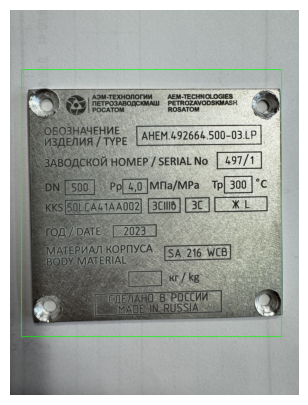

Текст на фото: "АНЕМ.492664.500-03LP "
----------------------
Название изображения: 459.jpg


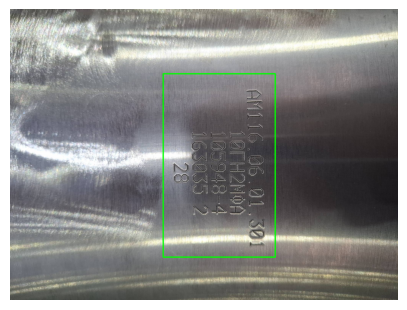

Текст на фото: "АМ116.06.01.301 "
----------------------


In [7]:
# КОД ДЛЯ ВИЗУАЛИЗАЦИИ

import os
import cv2
import matplotlib.pyplot as plt

def draw_box(image, bbox):
    H, W, _ = image.shape
    # Remove any extra whitespace and newlines before splitting
    bbox_clean = bbox.strip().replace('\\n', '')
    class_id, x_center, y_center, width, height = map(float, bbox_clean.split())
    
    x_min = int((x_center - width / 2) * W)
    y_min = int((y_center - height / 2) * H)
    x_max = int((x_center + width / 2) * W)
    y_max = int((y_center + height / 2) * H)
    
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), thickness=5)

for _, row in sub.iterrows():
    image_file = row['image_file']
    image_path = os.path.join(images_dir, image_file)
    
    if os.path.exists(image_path):
        print(f'Название изображения: {image_file}')
        
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Draw bounding box
        draw_box(image_rgb, row['label'])
        
        plt.figure(figsize=(5, 5))
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()
        
        # Print detected text
        print(f'Текст на фото: {row["label_text"]}')
        print('----------------------')
